Import essential libraries

In [1]:
import re
import torch
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments, BertForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

2025-07-07 21:34:17.792060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751924057.991723      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751924058.050579      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Helper functions

In [2]:
def plot_confusion_matrix(model, loader, classes):
    model.eval()
    y_pred = []
    y_test = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            y_pred.extend(preds.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Import datasets
<br>
ml-spring-nlp-dataset: https://www.kaggle.com/datasets/amirhosseinkanani/ml-spring-nlp-dataset
<br>
persian stop words: https://www.kaggle.com/datasets/alikhademi9876/stopwords

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_file_path = '/kaggle/input/ml-spring-nlp-dataset/train.csv'
test_file_path = '/kaggle/input/ml-spring-nlp-dataset/test.csv'
stopwords_file_path = '/kaggle/input/stopwords/persian stop words.txt'

train_df = pd.read_csv(train_file_path, index_col=0)
test_df = pd.read_csv(test_file_path, index_col=0)

with open(stopwords_file_path) as f:
  stopwords = f.read().split('\n')

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6125 entries, 0 to 6124
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6125 non-null   object
 1   emotion  6125 non-null   object
dtypes: object(2)
memory usage: 143.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1151 entries, 0 to 1150
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     1151 non-null   object
 1   emotion  1151 non-null   object
dtypes: object(2)
memory usage: 27.0+ KB


Preprocess dataset (Remove emojis, stopwords, and punctuations)

In [4]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "[\U00010000-\U0010ffff]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_digits(text):
    return re.sub(r'[0-9]', '', text)

def preprocess_text(df):
    # df['text'] = df['text'].apply(remove_emoji)
    df['text'] = df['text'].apply(remove_digits)
    # df['text'] = df['text'].apply(remove_punctuation)
    # df['text'] = df['text'].apply(remove_stopwords)
    
    return df

train_df = preprocess_text(train_df)
test_df = preprocess_text(test_df)
train_df.info()
test_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
Index: 6125 entries, 0 to 6124
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6125 non-null   object
 1   emotion  6125 non-null   object
dtypes: object(2)
memory usage: 143.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1151 entries, 0 to 1150
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     1151 non-null   object
 1   emotion  1151 non-null   object
dtypes: object(2)
memory usage: 27.0+ KB


,text,emotion
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD
...,...,...
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,SURPRISE
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,ANGRY
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,FEAR
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,SURPRISE


Label encode the data (also save the encoder for future use)

In [5]:
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['emotion'])
test_df['label'] = label_encoder.transform(test_df['emotion'])
joblib.dump(label_encoder, 'label_encoder.pkl')

train_df.drop(columns=['emotion'], inplace=True)
test_df.drop(columns=['emotion'], inplace=True)
train_df
test_df

,text,label
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,5
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,2
2,کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...,4
3,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,2
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,5
...,...,...
1146,یعنی این آهنگ مرغ سحر جوری ساخته شده و روی این...,2
1147,درود بر همه ایرانیان شریف که در این سرما در تظ...,2
1148,امروز تولدم است،عید است ولی شاد نیستم،عید و تو...,5
1149,لعنت به اونی که دلتنگ نگهت میداره...,5


Convert dataframes to datasets to use with bert model

In [6]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])
train_df.to_csv('train_preprocessed.csv')
valid_df.to_csv('valid_preprocessed.csv')
test_df.to_csv('test_preprocessed.csv')
dataset = load_dataset(
    'csv',
    data_files={
        'train': 'train_preprocessed.csv',
        'valid': 'valid_preprocessed.csv',
        'test': 'test_preprocessed.csv'
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Load ParsBert tokenizer and tokenize texts

In [7]:
model_name = "HooshvareLab/bert-fa-zwnj-base"

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define a function to tokenize the data
def tokenize_function(data):
    return tokenizer(data['text'], padding='max_length', truncation=True, max_length=512)

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename the 'label' column to 'labels' as expected by the model
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format for PyTorch
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split into train and test
train_dataset = tokenized_datasets['train']
valid_dataset = tokenized_datasets['valid']
test_dataset = tokenized_datasets['test']

tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

Map:   0%|          | 0/5512 [00:00<?, ? examples/s]

Map:   0%|          | 0/613 [00:00<?, ? examples/s]

Map:   0%|          | 0/1151 [00:00<?, ? examples/s]

Load ParsBert model

In [8]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
device = torch.device('cuda')
model.to(device)

pytorch_model.bin:   0%|          | 0.00/473M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Define training arguments and train model using f1-macro as metrics

In [ ]:
torch.cuda.empty_cache()

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    labels = labels
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=32,  # Batch size for training
    per_device_eval_batch_size=32,   # Batch size for evaluation
    warmup_steps=50,                 # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy="steps",           # Evaluate at the end of each epoch
    save_strategy="steps",           # Save at the end of each epoch
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # Specify metric to monitor for best model
    report_to="none",                  # Disable W&B integration
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

model.safetensors:   0%|          | 0.00/473M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,1.948800,1.889301,0.230016,0.145847,0.130987,0.087317
20,1.900500,1.825959,0.277325,0.202433,0.162883,0.115706
30,1.830600,1.759507,0.298532,0.270303,0.187347,0.127834
40,1.745000,1.675169,0.378467,0.482456,0.305299,0.263467
50,1.633200,1.541575,0.453507,0.486366,0.427147,0.434901
60,1.471500,1.365120,0.525285,0.588034,0.487970,0.499991
70,1.309300,1.240693,0.559543,0.569238,0.594368,0.569568
80,1.170400,1.171443,0.585644,0.663710,0.553105,0.558566
90,1.157200,1.200223,0.570962,0.594119,0.621823,0.589655
100,1.135600,1.110122,0.588907,0.644606,0.579078,0.594076


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=519, training_loss=0.831617325027554, metrics={'train_runtime': 1593.3553, 'train_samples_per_second': 10.378, 'train_steps_per_second': 0.326, 'total_flos': 4350999732019200.0, 'train_loss': 0.831617325027554, 'epoch': 3.0})

Re-initialize the trainer with the compute_metrics function and evaluate model

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 1.2936317920684814, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': 0.5899218071242398, 'eval_precision': 0.642994265149942, 'eval_recall': 0.5801760057479556, 'eval_f1': 0.5846770594353422, 'eval_runtime': 18.0415, 'eval_samples_per_second': 63.797, 'eval_steps_per_second': 1.995}


Get predictions and true labels and plot confusion matrix

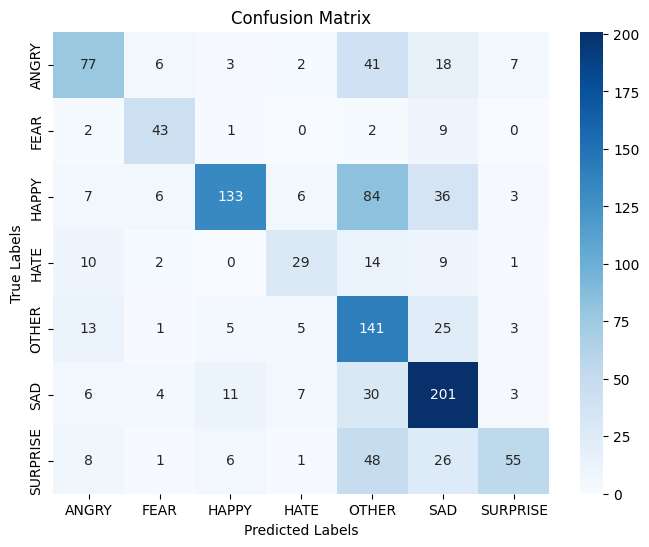

In [11]:
predicted_labels, true_labels, _ = trainer.predict(test_dataset)
predicted_labels = predicted_labels.argmax(axis=-1)

# Inverse transform to get the actual class names
true_class_names = label_encoder.inverse_transform(true_labels)
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Compute the confusion matrix
cm = confusion_matrix(true_class_names, predicted_class_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Save bert model and tokenizer for api use

In [12]:
model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")

('bert_model/tokenizer_config.json',
 'bert_model/special_tokens_map.json',
 'bert_model/vocab.txt',
 'bert_model/added_tokens.json')